# Revisiting the time dependence of SEI growth
## Peter Attia, last updated January 23, 2020
This notebook is used to explore the time dependence of SEI growth.

In [1]:
import glob
import os
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats.distributions import t
from sklearn.metrics import mean_squared_error, r2_score

Set plotting settings:

In [2]:
fig_width = 3.25 #ECS spec is 3.25" width
fig_height = (3/4)*fig_width # standard ratio
rcParams['lines.markersize'] = 6
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

## Preliminaries

Set $\alpha$ for 95% CI:

In [3]:
alpha = 0.05 # 95% confidence interval = 100*(1-alpha)

Create tval wrapper:

In [4]:
def tval(alpha, n, p):
    dof = max(0, n - p) # degrees of freedom
    tval = t.ppf(1 - alpha/2, dof)
    return tval

Define wrapper functions for `curve_fit` that returns both the 95% CIs and either $R^2$ or $R^2_{adj}$.
See [here](http://kitchingroup.cheme.cmu.edu/blog/2013/02/12/Nonlinear-curve-fitting-with-parameter-confidence-intervals/) for 95% CI reference
and [here](https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2) for $R^2_{adj}$ reference

In [5]:
def adj_r_squared(r_squared, n, p):
    return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

def curve_fit_with_r_squared(f, xdata, ydata, maxfev=10000):
    popt, pcov = curve_fit(f, xdata, ydata, maxfev=maxfev)
    
    n = len(xdata)
    p = len(popt)
    CIs = tval(alpha, n, p) * np.diag(pcov)**0.5
    
    y_pred = f(xdata, *popt)
    r_sq = r2_score(ydata, y_pred)
    
    return popt, CIs, r_sq

def curve_fit_with_adj_r_squared(f, xdata, ydata, maxfev=10000):
    popt, pcov = curve_fit(f, xdata, ydata, maxfev=maxfev)

    n = len(xdata)
    p = len(popt)
    CIs = tval(alpha, n, p) * np.diag(pcov)**0.5
    
    y_pred = f(xdata, *popt)
    r_sq = r2_score(ydata, y_pred)
    adj_r_sq = adj_r_squared(r_sq, n, p)
    
    return popt, CIs, adj_r_sq

## Illustration
First, we illustrate how $t^{0.5}$ models can "look good" but still not capture the true functional form.

We primarily explore the three functional forms below: $y = ax^{0.5}+b$, $y = ax^{b}$, and $y = ax^{b}+c$.

In [6]:
def t_onehalf(x, a, b):
    return a * x**0.5 + b

def power1(x, a, b):
    return a * x**b

def power2(x, a, b, c):
    return a * x**b + c

Here we illustrate $ y=ax^{0.5}+b $ fits to a $ y=ax^b $ function, along with its residual:

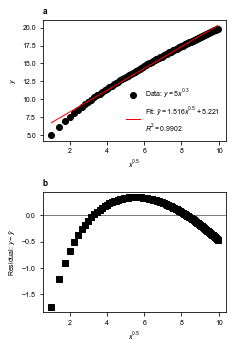

In [7]:
exponent = 0.3

x = np.arange(1, 100) # example data
sqrt_x = np.sqrt(x)
y = 5 * (x**exponent)

popt, CIs, r_squared = curve_fit_with_r_squared(t_onehalf, x, y)

plt.subplots(figsize=(fig_width, fig_height*2), nrows=2)
plt.subplot(211)
plt.title('a', loc='left', weight='bold')

plt.plot(sqrt_x, y, 'ko',
         label='Data: ' + r'$y=5x^{' + str(exponent) + '}$')
plt.plot(sqrt_x, t_onehalf(x, *popt), 'r-',
         label='Fit: ' + r'$\hat{y}=%5.3fx^{0.5} + %5.3f$' % tuple(popt)
         + '\n' + r'$R^2=%3.4f$' %(r_squared))
plt.xlabel(r'$x^{0.5}$')
plt.ylabel(r'$y$')
plt.legend()

plt.subplot(212)
plt.title('b', loc='left', weight='bold')

plt.axhline(0, color='tab:gray')
plt.plot(x**0.5, y-t_onehalf(x, *popt), 'ks')

plt.xlabel(r'$x^{0.5}$')
plt.ylabel(r'Residual: $y-\hat{y}$')

plt.tight_layout()
plt.savefig('figures/example.eps', bbox_inches='tight', format='eps')

## Literature data re-analysis
Next, we re-analyze literature data.
The data from the C/10, 30&deg;C series of Figure 7 of [Smith et al.](https://doi.org/10.1149/1.3557892) was extracted with [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) using three different extraction techniques. The figure is reproduced here:<br>
<img src="smith/Smith_et_al_2011_Fig7.png" width="400">

We first evaluate the accuracy of the WebPlotDigitizer tool. I performed three extractions of the 30 degree C data.

In [8]:
csvs = glob.glob('smith/Smith_et_al_2011_Fig7_30degC_Cover10*.{}'.format('csv')) #two-column array, x=t^0.5, y=Qirr
Smith_30C_data = []
data_shape = np.genfromtxt(csvs[0], delimiter=',').shape
x = np.zeros((data_shape[0], 3))
y = np.zeros((data_shape[0], 3))

for k, csv in enumerate(csvs):
    d = np.genfromtxt(csv, delimiter=',')
    Smith_30C_data.append(d)
    x[:,k] = d[:,0]
    y[:,k] = d[:,1]

Plot the three extractions together:

Text(0, 0.5, '$Q_{irr}$ (mAh/g)')

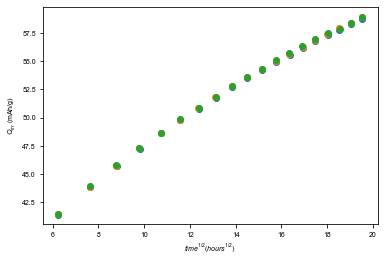

In [9]:
for d in Smith_30C_data:
    plt.plot(d[:,0], d[:,1], 'o')
plt.xlabel(r'$time^{1/2} (hours^{1/2})$')
plt.ylabel(r'$Q_{irr}$ (mAh/g)')

Triplicate extractions look very similar. Next. we determine the relative standard error (rse) to quantify the extraction error:

Mean relative standard error = 0.095%
Max relative standard error = 0.151%


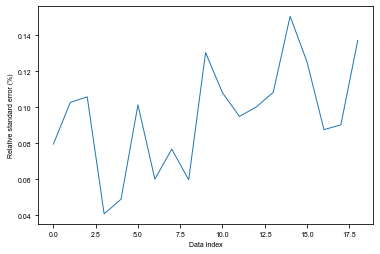

In [10]:
means = np.mean(y, axis=1)
se = 1.96*np.std(y, axis=1)/np.sqrt(3)
rse = se/means*100
plt.plot(rse)
plt.xlabel('Data index')
plt.ylabel('Relative standard error (%)')
print('Mean relative standard error = {:.3f}%'.format(np.mean(rse)))
print('Max relative standard error = {:.3f}%'.format(np.max(rse)))

Extraction errors are quite low. For now we'll assume we can accurately extract the data, although of course there could be systematic extraction errors (we don't have the true values for the true quantification).

## Test on 30 deg C data from Smith et al

Here we demo the analysis procedure for a sample dataset from Smith et al. (This figure used to be a main text figure, but it was removed since it is redundant with a later figure)

In [11]:
x = Smith_30C_data[0][:,0]**2 # work with x in units of time, not sqrt(time)
y = Smith_30C_data[0][:,1]

popt1, CIs1, adj_r2_1 = curve_fit_with_adj_r_squared(t_onehalf, x, y)
popt2, CIs2, adj_r2_2 = curve_fit_with_adj_r_squared(power1, x, y)
popt3, CIs3, adj_r2_3 = curve_fit_with_adj_r_squared(power2, x, y)

print('Adjusted R^2 for at^1/2+b: {:.4f}'.format(adj_r2_1))
print('Adjusted R^2 for at^b: {:.4f}'.format(adj_r2_2))
print('Adjusted R^2 for at^b+c: {:.4f}'.format(adj_r2_3))

Adjusted R^2 for at^1/2+b: 0.9907
Adjusted R^2 for at^b: 0.9996
Adjusted R^2 for at^b+c: 0.9999


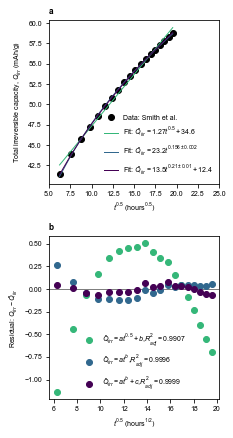

In [12]:
colors = cm.viridis(np.linspace(0, 1, 4))
colors = colors[:,0:3]

# start plotting
plt.subplots(figsize=(fig_width, fig_height*2.5), nrows=2)
plt.subplot(211)
plt.title('a',loc='left',weight='bold')

plt.plot(x**0.5, y, 'ko',
         label='Data: Smith et al.')
plt.plot(x**0.5, t_onehalf(x, *popt1), color=colors[2,:],
         label='Fit: ' + r'$\hat{Q}_{irr}=%5.2ft^{0.5} + %5.1f$' % tuple(popt1))
plt.plot(x**0.5, power1(x, *popt2), color=colors[1,:],
         label='Fit: ' + r'$\hat{Q}_{irr}=%5.1ft^{%5.3f \pm %5.3f}$' % tuple(np.append(popt2, CIs2[1])))
plt.plot(x**0.5, power2(x, *popt3), color=colors[0,:],
         label='Fit: ' + r'$\hat{Q}_{irr}=%5.1ft^{%5.2f \pm %5.2f} + %5.1f$' % tuple(np.insert(popt3, 2, CIs3[1])))

plt.xlabel(r'$t^{0.5}$' + ' (hours' + r'$^{0.5}$' + ')')
plt.ylabel('Total irreversible capacity, $Q_{irr}$ (mAh/g)')
plt.xlim((5,25))
plt.legend()

## residual analysis
plt.subplot(212)
plt.title('b', loc='left', weight='bold')

plt.axhline(0, color='tab:gray')
plt.plot(x**0.5, y-t_onehalf(x, *popt1),'o',color=colors[2,:],
        label=r'$\hat{Q}_{irr}=at^{0.5}+b$'+','+r'$R^2_{adj}=%.4f$' %(adj_r2_1))
plt.plot(x**0.5 ,y-power1(x, *popt2),'o',color=colors[1,:],
        label=r'$\hat{Q}_{irr}=at^{b}$'+','+r'$R^2_{adj}=%.4f$' %(adj_r2_2))
plt.plot(x**0.5, y-power2(x, *popt3),'o', color=colors[0,:],
         label=r'$\hat{Q}_{irr}=at^{b}+c$'+','+r'$R^2_{adj}=%.4f$' %(adj_r2_3))

plt.xlabel(r'$t^{0.5}$' + ' (hours' + r'$^{1/2}$' + ')')
plt.ylabel('Residual: ' + r'$Q_{irr}-\hat{Q}_{irr}$')
#plt.xlim((5,20))
plt.legend()

plt.tight_layout()
plt.savefig('figures/Smith_30C_residuals.eps', bbox_inches='tight', format='eps')

The residual for the $t^{0.5}$ model is definitely off.

## Prediction
As an example, try prediction of last 20% of data points, using first 80% of data points for training

In [13]:
training_fraction = 0.8 # 80%
threshold = int(np.floor(np.size(x)*training_fraction)) # train/test threshold for indexing

# split into test/train
x_train = Smith_30C_data[0][:threshold,0]**2
y_train = Smith_30C_data[0][:threshold,1]
x_test = Smith_30C_data[0][threshold:,0]**2
y_test = Smith_30C_data[0][threshold:,1]

# fit training data
popt1 = curve_fit(t_onehalf, x_train, y_train)[0]
popt2 = curve_fit(power1, x_train, y_train)[0]
popt3 = curve_fit(power2, x_train, y_train)[0]

# calculate rmse
rmse1 = np.sqrt(mean_squared_error(y_test, t_onehalf(x_test, *popt1)))
rmse2 = np.sqrt(mean_squared_error(y_test, power1(x_test, *popt2)))
rmse3 = np.sqrt(mean_squared_error(y_test, power2(x_test, *popt3)))

print('RMSE for at^1/2+b: %.4f' % rmse1)
print('RMSE for at^b: %.4f' % rmse2)
print('RMSE for at^b+c: %.4f' % rmse3)

RMSE for at^1/2+b: 1.0360
RMSE for at^b: 0.0889
RMSE for at^b+c: 0.1399


The RMSE of the last model is ~10x smaller than that of the first model.

Plot the results:

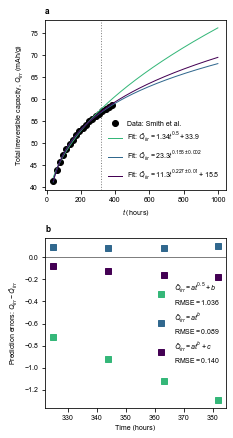

In [14]:
x_future = np.arange(np.min(x_train), 1000)

plt.subplots(figsize=(fig_width, fig_height*2.5), nrows=2)
plt.subplot(211)
plt.title('a', loc='left', weight='bold')


plt.axvline(np.mean(x[threshold-1:threshold+1]), color='tab:gray', linestyle=':', zorder=0)
plt.plot(x, y, 'ko', label='Data: Smith et al.')
plt.plot(x_future, t_onehalf(x_future, *popt1), color=colors[2,:],
         label='Fit: ' + r'$\hat{Q}_{irr}=%.2ft^{0.5} + %5.1f$' % tuple(popt1))
plt.plot(x_future, power1(x_future, *popt2), color=colors[1,:],
         label='Fit: ' + r'$\hat{Q}_{irr}=%.1ft^{%5.3f \pm %5.3f}$' % tuple(np.append(popt2, CIs2[1])))
plt.plot(x_future, power2(x_future, *popt3), color=colors[0,:],
         label='Fit: ' + r'$\hat{Q}_{irr}=%.1ft^{%5.3f \pm %5.2f} + %5.1f$' % tuple(np.insert(popt3, 2, CIs3[1])))

plt.xlabel(r'$t$' + ' (hours)')
plt.ylabel('Total irreversible capacity, $Q_{irr}$ (mAh/g)')
plt.legend(framealpha=1, edgecolor='white').set_zorder(1)

# Predictions
plt.subplot(212)
plt.title('b', loc='left', weight='bold')

plt.axhline(0, color='tab:gray')
plt.plot(x_test, y_test - t_onehalf(x_test, *popt1), 's', color=colors[2,:],
         label=r'$\hat{Q}_{irr}=at^{0.5}+b$' + '\nRMSE' + r'$=%3.3f$' %(rmse1))
plt.plot(x_test, y_test - power1(x_test, *popt2), 's', color=colors[1,:],
         label=r'$\hat{Q}_{irr}=at^{b}$' + '\nRMSE' + r'$=%3.3f$' %(rmse2))
plt.plot(x_test, y_test - power2(x_test, *popt3), 's', color=colors[0,:],
         label=r'$\hat{Q}_{irr}=at^{b}+c$' + '\nRMSE' + r'$=%3.3f$' %(rmse3))

plt.xlabel('Time (hours)')
plt.ylabel('Prediction errors: ' + r'$Q_{irr}-\hat{Q}_{irr}$')
plt.legend()

plt.tight_layout()
plt.savefig('figures/Smith_30C_predictions.eps',bbox_inches='tight',format='eps')

## Moving window exponent

Does the exponent become closer to 0.5 at later times? Here we see how the exponent changes throughtout the dataset. We use a five-point moving window.

In [15]:
CIs

array([0.0303535 , 0.21463166])

In [16]:
n_points_in_moving_window = 5

thresholds = np.arange(len(x) - n_points_in_moving_window + 1)
exponent2 = np.zeros(thresholds.size)
error2 = np.zeros(thresholds.size)
exponent3 = np.zeros(thresholds.size)
error3 = np.zeros(thresholds.size)

for k, threshold in enumerate(thresholds):
    # define subset
    x_subset = Smith_30C_data[0][threshold:threshold + n_points_in_moving_window,0]**2
    y_subset = Smith_30C_data[0][threshold:threshold + n_points_in_moving_window,1]
    
    # fit subset
    popt, CIs, R2 = curve_fit_with_adj_r_squared(power1, x_subset, y_subset)
    exponent2[k] = popt[1]
    error2[k] = CIs[1]
    
    popt, CIs, R2 = curve_fit_with_adj_r_squared(power2, x_subset, y_subset, maxfev=50000)
    exponent3[k] = popt[1]
    error3[k] = CIs[1]

print('2-param fit: mean(b) = {:.3f}, std(b) = {:.3f}'.format(np.mean(exponent2), np.std(exponent2)))
print('3-param fit: mean(b) = {:.3f}, std(b) = {:.3f}'.format(np.mean(exponent3), np.std(exponent3)))

2-param fit: mean(b) = 0.157, std(b) = 0.004
3-param fit: mean(b) = 0.180, std(b) = 0.135


Plot the results:

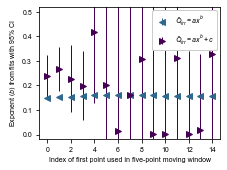

In [17]:
plt.subplots(figsize=(fig_width, fig_height))
plt.errorbar(thresholds, exponent2, error2, fmt='<', color=colors[1,:], label=r'$\hat{Q}_{irr}=ax^b$')
plt.errorbar(thresholds, exponent3, error3, fmt='>', color=colors[0,:], label=r'$\hat{Q}_{irr}=ax^b+c$')
plt.xlabel('Index of first point used in five-point moving window')
plt.ylabel('Exponent (' + r'$b$' + ') from fits with 95% CI')
plt.ylim((-0.02,0.52))
plt.legend(frameon=True, framealpha=1)
plt.savefig('figures/Smith_30C_exponent.eps', bbox_inches='tight', format='eps')

## Literature data re-analysis

In this section, we systematically reanalyze many purported $ t^{0.5} $ fits from literature.

### Helper functions

We first define a set of helper functions for loading data, plotting, etc:

In [18]:
def sortKeyFunc(s):
    return os.path.basename(s)

Create dataset loading function:

In [19]:
def load_dataset(author):
    csvs = glob.glob(author+'/'+author+'_et_al*.{}'.format('csv')) #two-column array
    csvs.sort(key=sortKeyFunc) # glob returns list with arbitrary order

    print(csvs)

    data = []

    for k, csv in enumerate(csvs):
        d = np.genfromtxt(csv,delimiter=',')
        data.append(d)
        
    return data

Create `Labels` `namedtuple` as a container for dataset-specific properties: 

In [20]:
Labels = namedtuple('Labels', ['legend_labels', 'x_label', 'y_label', 'dataset_name',
                               'y_symbol', 'y_symbol_pred', 'y_unit', 'switch_xy', 'square_x'])

Create helper function for plotting the raw data:

In [21]:
def plot_raw_data_subplot(data, labels, markers):
    
    x_max = 0
    
    # account for different types of raw data
    exponent = 1
    if labels.square_x:
        exponent = 2
    
    # legend tweaking based on number of series
    colon_str = ''
    if len(data) > 1:
        colon_str = ':\n'
    
    for k, dataset in enumerate(data):
        
        x = dataset[:,0]**exponent
        y = dataset[:,1]
        
        if labels.switch_xy:
            x, y = y, x
        
        x_max = np.max([np.max(x), x_max])

        popt1, CIs1, adj_r2_1 = curve_fit_with_adj_r_squared(t_onehalf, x, y)
        popt2, CIs2, adj_r2_2 = curve_fit_with_adj_r_squared(power1, x, y)
        popt3, CIs3, adj_r2_3 = curve_fit_with_adj_r_squared(power2, x, y)
                
        # Rounding
        prec2 = -int(np.floor(np.log10(CIs2[1])))
        try:
            prec3 = -int(np.floor(np.log10(CIs3[1])))
        except ValueError: # CI = nan
            prec3 = 0
        
        label = labels.legend_labels[k] + colon_str \
        + r'$' + labels.y_symbol_pred + '=%.3gt^{0.5} %+.3g$' % tuple(popt1) \
        + ', ' + r'$R_{adj}^2=%.4f}$' % adj_r2_1 + '\n' \
        + r'$' + labels.y_symbol_pred + ('=%.3gt^{%.'+str(prec2)+'f \pm %.'+str(prec2)+'f}$') % tuple(np.append(popt2, CIs2[1])) \
        + ', ' + r'$R_{adj}^2=%.4f}$' % adj_r2_2 + '\n' \
        + r'$' + labels.y_symbol_pred + ('=%.3gt^{%.'+str(prec3)+'f \pm %.'+str(prec3)+'f} %+.3g$') % tuple(np.insert(popt3, 2, CIs3[1])) \
        + ', ' + r'$R_{adj}^2=%.4f}$' % adj_r2_3
        
        # special case for carbon black data
        if popt3[0] > 1000:
            label = labels.legend_labels[k] + colon_str \
            + r'$' + labels.y_symbol_pred + '=%.3g t^{0.5} %+.3g$' % tuple(popt1) \
            + ', ' + r'$R_{adj}^2=%.4f}$' % adj_r2_1 + '\n' \
            + r'$' + labels.y_symbol_pred + ('=%.3gt^{%.'+str(prec2)+'f \pm %.'+str(prec2)+'f}$') % tuple(np.append(popt2, CIs2[1])) \
            + ', ' + r'$R_{adj}^2=%.4f}$' % adj_r2_2 + '\n' \
            + r'$' + labels.y_symbol_pred + ('=%.4g t^{%.'+str(prec3)+'f \pm %.'+str(prec3)+'f} %+.4g$') % tuple(np.insert(popt3, 2, CIs3[1])) \
            + ', ' + r'$R_{adj}^2=%.4f}$' % adj_r2_3
        
        plt.plot(x, y, linestyle='None', marker=markers[k], label=label, color=colors[k])

    plt.xlabel(labels.x_label)
    plt.ylabel('{} {}'.format(labels.y_label, labels.y_unit))
    
    # Define standard xlim
    print('x_max of dataset = {}'.format(x_max))
    xlim_min = -0.1 * x_max
    xlim_max = 1.15 * x_max
    plt.xlim((xlim_min, xlim_max))
    
    return (xlim_min, xlim_max)

Create helper function for plotting residuals:

In [22]:
def plot_residual_subplot(data, index, labels, xlim, marker):
    
    colors = cm.viridis(np.linspace(0, 1, 4))
    colors = colors[:,0:3]
    
    exponent = 1
    if labels.square_x:
        exponent = 2
    
    x = data[index][:,0]**exponent
    y = data[index][:,1]
    
    if labels.switch_xy:
        x, y = y, x

    popt1, CIs1, adj_r2_1 = curve_fit_with_adj_r_squared(t_onehalf, x, y)
    popt2, CIs2, adj_r2_2 = curve_fit_with_adj_r_squared(power1, x, y)
    popt3, CIs3, adj_r2_3 = curve_fit_with_adj_r_squared(power2, x, y)
    
    plt.axhline(0,color='tab:gray')
    
    plt.plot(x, y - t_onehalf(x, *popt1), marker, color = colors[2, :], label=r'$y=ax^{0.5}+b$')
    plt.plot(x, y - power1(x, *popt2), marker, color = colors[1,:], label=r'$y=ax^{b}$')
    plt.plot(x ,y - power2(x, *popt3), marker, color = colors[0,:], label=r'$y=ax^{b}+c$')
             
    y_label = 'Residual: '+ r'$' + labels.y_symbol +'-' + labels.y_symbol_pred + '$' + ' ' + labels.y_unit
    
    plt.xlabel(labels.x_label)
    plt.ylabel(y_label)
    plt.xlim(xlim)
    
    # annoying hack for Wright dataset
    legend_loc = 'best'
    if labels.dataset_name == 'Wright':
        legend_loc = 'lower right'
        
    plt.legend(title = labels.legend_labels[index], loc=legend_loc)

Helper function for plotting raw data in subplot (a), plotting the residuals of the first and last series in subplots (b) and (c), respectively, and plotting a large legend in the top right quadrant.

In [23]:
def plot_dataset(data, labels):
    
    # Find number of datasets
    n_datasets = len(data)
    
    # Initialize figure
    plt.figure(figsize=(fig_width*2, fig_height*2.5))

    # (a): Plot raw data
    ax = plt.subplot(221)
    plt.title('a', loc='left', weight='bold')
    xlim = plot_raw_data_subplot(data, labels, markers)

    # (b): Plot first series
    plt.subplot(223)
    plt.title('b', loc='left', weight='bold')
    plot_residual_subplot(data, 0, labels, xlim, markers[0])

    # (c): Plot last series
    plt.subplot(224)
    plt.title('c', loc='left', weight='bold')
    plot_residual_subplot(data, n_datasets-1, labels, xlim, markers[-1])

    plt.tight_layout()
    
    ax.legend(bbox_to_anchor=(0.55, 0.75), loc='center left', labelspacing=1.5,
              bbox_transform=plt.gcf().transFigure)
    
    # Save
    figure_filename = 'figures/{}.eps'.format(labels.dataset_name)
    plt.savefig(figure_filename, bbox_inches='tight', format='eps')

### Smith et al.

We now look at the rest of the C/10 data in Figure 7 of Smith et al.

We don't use the dataset loading helper function since we just want to load the new Smith et al csvs

In [24]:
# Load other Smith et al csvs
csvs = glob.glob('smith/Smith_et_al_2011_Fig7_[!30]*.{}'.format('csv')) #two-column array, x=t^0.5, y=Qirr
csvs.sort(key=sortKeyFunc) # glob returns list with arbitrary order

print(csvs)

Smith_data = []
Smith_data.append(Smith_30C_data[0]) # 30 deg C

for k, csv in enumerate(csvs):
    d = np.genfromtxt(csv,delimiter=',')
    Smith_data.append(d)

['smith/Smith_et_al_2011_Fig7_40degC_Cover10.csv', 'smith/Smith_et_al_2011_Fig7_50degC_Cover10.csv']


Plot results:

x_max of dataset = 397.0155552286443


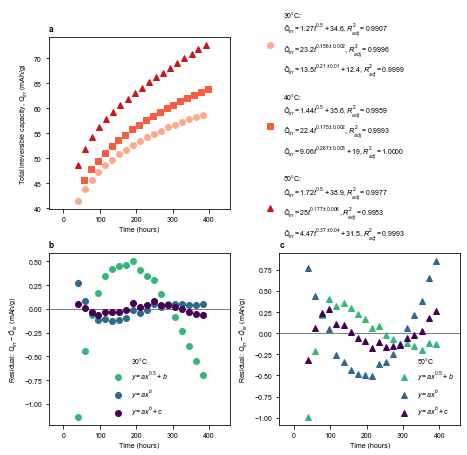

In [25]:
colors = cm.Reds(np.linspace(0.3, 1, 4))
colors = colors[:,0:3]
markers = ['o','s','^']

Smith_labels = Labels(legend_labels = [r'$30\degree$'+'C',r'$40\degree$'+'C',r'$50\degree$'+'C'], 
                      x_label = 'Time (hours)',
                      y_label = 'Total irreversible capacity, $Q_{irr}$',
                      dataset_name = 'Smith',
                      y_symbol = 'Q_{irr}',
                      y_symbol_pred = r'\hat{Q}_{irr}',
                      y_unit = '(mAh/g)',
                      switch_xy = False,
                      square_x = True)

plot_dataset(Smith_data, Smith_labels)

### Wright et al
[Link to paper](https://doi.org/10.1016/S0378-7753(02)00210-0)

The 60&deg;C data was hard to extract, so we extract all but that one.
<br>
<img src="wright/Wright_et_al_2002_Fig1.png" width="600">

In [26]:
Wright_data = load_dataset('Wright')

['Wright/Wright_et_al_2002_Fig1_40C.csv', 'Wright/Wright_et_al_2002_Fig1_50C.csv', 'Wright/Wright_et_al_2002_Fig1_70C.csv']


Convert ohms to milliohms to improve figure readability:

In [27]:
for k in range(len(Wright_data)):
    Wright_data[k][:,1] *= 1000

x_max of dataset = 27.016774772196914


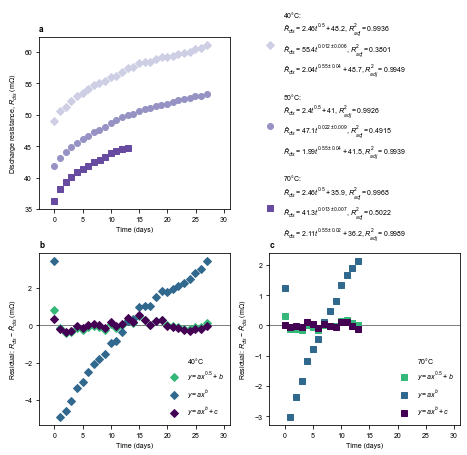

In [28]:
colors = cm.Purples(np.linspace(0.3, 1, 4))
colors = colors[:,0:3]
markers = ['D','o','s']

Wright_labels = Labels(legend_labels = [r'$40\degree$'+'C',r'$50\degree$'+'C',r'$70\degree$'+'C'],
                       x_label = 'Time (days)',
                       y_label = r'Discharge resistance, $R_{dis}$',
                       dataset_name = 'Wright',
                       y_symbol = 'R_{dis}',
                       y_symbol_pred = r'\hat{R}_{dis}',
                       y_unit = r'(m$\Omega$)',
                       switch_xy = False,
                       square_x = True)

plot_dataset(Wright_data, Wright_labels)

### Broussely et al

[Link to paper](https://doi.org/10.1016/S0378-7753(01)00722-4)

We use the "proto" datasets here since they are the easiest to extract
<br>
<img src="broussely/Broussely_et_al_2001_Fig6.png" width="600">

In [29]:
Broussely_data = load_dataset('Broussely')

['Broussely/Broussely_et_al_2001_Fig6_30C.csv', 'Broussely/Broussely_et_al_2001_Fig6_60C.csv']


x_max of dataset = 450.6313751047589


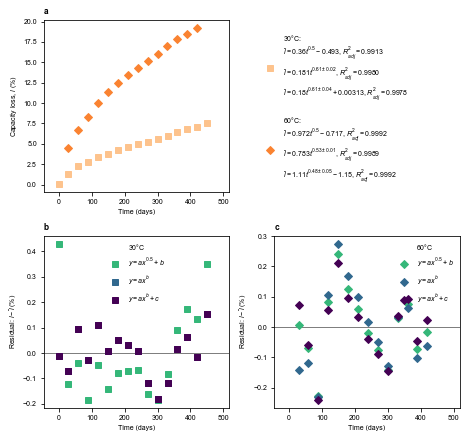

In [30]:
colors = cm.Oranges(np.linspace(0.3, 1, 4))
colors = colors[:,0:3]
markers = ['s','D']

Broussely_labels = Labels(legend_labels = [r'$30\degree$'+'C',r'$60\degree$'+'C'],
                          x_label = 'Time (days)',
                          y_label = 'Capacity loss, ' + r'$l$',
                          dataset_name = 'Broussely',
                          y_symbol = 'l',
                          y_symbol_pred = r'\hat{l}',
                          y_unit = '(%)',
                          switch_xy = True,
                          square_x = False)

plot_dataset(Broussely_data, Broussely_labels)

### Smith et al (paper 2)
[Link to paper](https://doi.org/10.1149/1.3625232)

We analyze the data in Figure 2b
<br>
<img src="smith2/Smith2_et_al_2011_Fig8.png" width="600">

In [31]:
Smith2_data = load_dataset('Smith2')

['Smith2/Smith2_et_al_2011_Fig8b.csv']


Manual intervention:
1. For the $x$ axis, we can calculate cycle number directly instead of using the values from WebPlotDigitizer
2. For the $y$ axis, we can calculate percent capacity fade to obtain an increasing function (for consistency with other datasets). Using percent capacity fade (as opposed to fractional capacity fade) gives us more readable plots

In [32]:
Smith2_data[0][:,0] = np.arange(len(Smith2_data[0][:,1])) + 1
Smith2_data[0][:,1] = 100*(1 - Smith2_data[0][:,1]/Smith2_data[0][0,1])

In [33]:
colors = np.asarray([[0, 0, 0],
                     [0, 0, 0],
                     [0, 0, 0]])
markers = ['o']

Smith2_labels = Labels(legend_labels = [''], 
                      x_label = 'Cycle number',
                      y_label = 'Capacity loss, $l$',
                      dataset_name = 'Smith2',
                      y_symbol = 'l',
                      y_symbol_pred = r'\hat{l}',
                      y_unit = '(%)',
                      switch_xy = False,
                      square_x = False)

Don't use `plot_dataset` function since we only have one series

x_max of dataset = 41.0


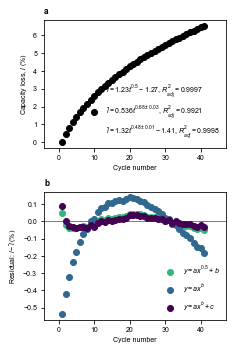

In [34]:
n_datasets = len(Smith2_data)

# Initialize figure
plt.figure(figsize=(fig_width, fig_height*2))

# (a): Plot raw data
ax = plt.subplot(211)
plt.title('a', loc='left', weight='bold')
xlim = plot_raw_data_subplot(Smith2_data, Smith2_labels, markers)
ax.legend()

## Plot first series
plt.subplot(212)
plt.title('b',loc='left',weight='bold')
plot_residual_subplot(Smith2_data, 0, Smith2_labels, xlim, markers[0])
    
min_y = plt.gca().get_ylim()[0]
plt.annotate(Smith2_labels.legend_labels[0], xy=((xlim[1]-5)/2, min_y), xytext=(0, 3),
             textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
figure_filename = 'figures/{}.eps'.format(Smith2_labels.dataset_name)
plt.savefig(figure_filename, bbox_inches='tight', format='eps')

### Fathi et al
[Link to paper](https://doi.org/10.1149/2.0321410jes)

Because this plot was saved as a vector plot, we can more easily extract the data. (I <3 vector formats!)

Here, we focus on Groups 3 and 4 since they have the most data. We extract the data from Figure 2a since the *x* axis units are time, but we replot the data in the format of Figure 2b (and convert to units of percent).
<br>
<img src="fathi/Fathi_et_al_2014_Fig2.png" width="400">

In [35]:
Fathi_data = load_dataset('Fathi')

['Fathi/Fathi_et_al_2014_Fig2a_group3a.csv', 'Fathi/Fathi_et_al_2014_Fig2a_group3b.csv', 'Fathi/Fathi_et_al_2014_Fig2a_group4a.csv', 'Fathi/Fathi_et_al_2014_Fig2a_group4b.csv']


The plot gets pretty crowded with all four datasets. I just use one series from each group:

In [36]:
del Fathi_data[1:3]

Also convert this dataset to an increasing function, with nice values (%)

In [37]:
for d in Fathi_data:
    d[:,1] = 100*(1 - d[:,1])

x_max of dataset = 10.946496253391967


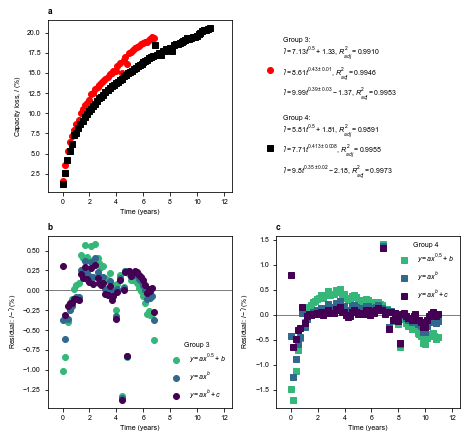

In [38]:
colors = np.asarray([[1, 0, 0],
                     [0, 0, 0]])
markers = ['o','s']

Fathi_labels = Labels(legend_labels = ['Group 3', 'Group 4'],
                      x_label = 'Time (years)',
                      y_label = 'Capacity loss, $l$',
                      dataset_name = 'Fathi',
                      y_symbol = 'l',
                      y_symbol_pred = r'\hat{l}',
                      y_unit = '(%)',
                      switch_xy = False,
                      square_x = False)

plot_dataset(Fathi_data, Fathi_labels)

### Carbon black

This is data that I've collected on carbon black/Li half cells. First we preprocess the raw data:

['carbon black/cellA_Cover20_CB5.txt', 'carbon black/cellH_Cover20_CC2.txt', 'carbon black/cellI_Cover20_CC3.txt']


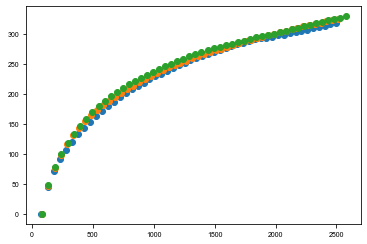

In [39]:
author = 'carbon black'
txts = glob.glob(author + '/*.{}'.format('txt'))
txts.sort(key=sortKeyFunc)
print(txts)

# Divide by masses to get mAh/g
mass = [0.855,0.930,0.952] # cells A, H, I respectively

# Switch order for more natural ordering
txts[0], txts[1] = txts[1], txts[0]
mass[0], mass[1] = mass[1], mass[0] 

time = []
SEI = []
CB_data_time = []
CB_data_cyclenum = []
CB_data_time_subfirstcycle = []
CB_data_cyclenum_subfirstcycle = []

for k, txt in enumerate(txts):
    d = np.genfromtxt(txt,skip_header=1)
    m = mass[k]/1000 # mg -> g
    
    #Q
    Q = d[:,2]/m # mAh -> mAh/g

    # Qd and Qc vs n
    peaks = find_peaks(Q)[0]
    Qpeaks = Q[peaks]
    Qd = Qpeaks[0::2]
    Qc = Qpeaks[1::2]
    
    # t (all cells cycle at C/20, with 1C = 200 mA/g -> C/20 = 10 mA/g)
    t_k = np.cumsum(Qpeaks)/10 # t = Q/I; (mAh/g / mA/g) -> h
    t_k = t_k[1::2]
    
    SEI_k = np.cumsum(Qd[:-1] - Qc)
    
    time.append(t_k) # time per cycle counts after discharge
    SEI.append(SEI_k)
    CB_data_time.append(np.vstack((t_k, SEI_k)).T)
    
    # Compute x as cycle number
    cyclenum_k = np.arange(len(SEI_k)) + 1
    CB_data_cyclenum.append(np.vstack((cyclenum_k, SEI_k)).T)
    
    SEI_k -= SEI_k[0]
    CB_data_time_subfirstcycle.append(np.vstack((t_k, SEI_k)).T)
    CB_data_cyclenum_subfirstcycle.append(np.vstack((cyclenum_k, SEI_k)).T)
    
    plt.plot(time[k],SEI[k],'o')

#### $Q_{SEI}$ vs time

x_max of dataset = 2574.619326000898


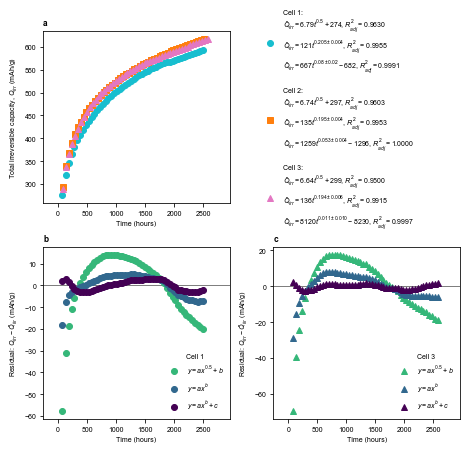

In [40]:
colors = ['tab:cyan','tab:orange','tab:pink']
markers = ['o','s','^']

CB_labels = Labels(legend_labels = ['Cell 1', 'Cell 2', 'Cell 3'],
                      x_label = 'Time (hours)',
                      y_label = 'Total irreversible capacity, $Q_{irr}$',
                      dataset_name = 'CB_time',
                      y_symbol = r'Q_{irr}',
                      y_symbol_pred = r'\hat{Q}_{irr}',
                      y_unit = '(mAh/g)',
                      switch_xy = False,
                      square_x = False)

plot_dataset(CB_data_time, CB_labels)

#### $Q_{SEI}$ vs time (subtracted first cycle)

x_max of dataset = 2574.619326000898


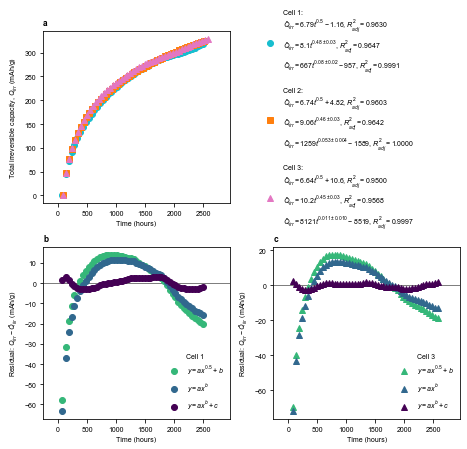

In [41]:
colors = ['tab:cyan','tab:orange','tab:pink']
markers = ['o','s','^']

CB_labels = Labels(legend_labels = ['Cell 1', 'Cell 2', 'Cell 3'],
                      x_label = 'Time (hours)',
                      y_label = 'Total irreversible capacity, $Q_{irr}$',
                      dataset_name = 'CB_time_subfirstcycle',
                      y_symbol = r'Q_{irr}',
                      y_symbol_pred = r'\hat{Q}_{irr}',
                      y_unit = '(mAh/g)',
                      switch_xy = False,
                      square_x = False)

plot_dataset(CB_data_time_subfirstcycle, CB_labels)

#### $Q_{SEI}$ vs cycle number

/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


x_max of dataset = 51.0


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


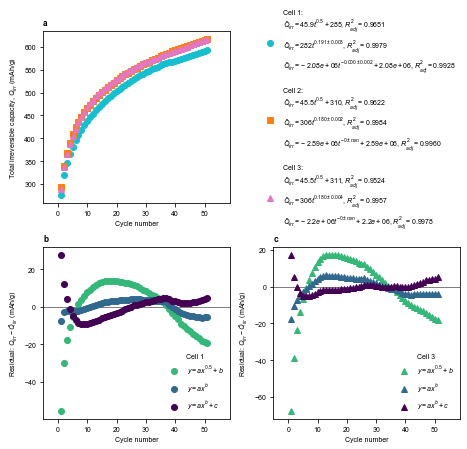

In [42]:
colors = ['tab:cyan','tab:orange','tab:pink']
markers = ['o','s','^']

CB_labels = Labels(legend_labels = ['Cell 1', 'Cell 2', 'Cell 3'],
                      x_label = 'Cycle number',
                      y_label = 'Total irreversible capacity, $Q_{irr}$',
                      dataset_name = 'CB_cyclenum',
                      y_symbol = r'Q_{irr}',
                      y_symbol_pred = r'\hat{Q}_{irr}',
                      y_unit = '(mAh/g)',
                      switch_xy = False,
                      square_x = False)

plot_dataset(CB_data_cyclenum, CB_labels)